In [1]:
import geopandas as gpd
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import matplotlib.pyplot as plt
import folium
import seaborn as sns

## Collection events

In [2]:
#waste_aust = pd.read_csv(r'C:\Users\fredericorodrigues\Downloads\waste_collection.csv')  
waste_aust = pd.read_csv('waste_collection.csv')  

In [3]:
waste_aust.dtypes

Report Date      object
Load Type        object
Load Time        object
Load Weight     float64
Dropoff Site     object
Route Type       object
Route Number     object
Load ID           int64
dtype: object

In [4]:
waste_aust['Load Time'] = pd.to_datetime(waste_aust['Load Time'])

In [5]:
cal = calendar()
holidays = cal.holidays(start=waste_aust['Load Time'].min(), end=waste_aust['Load Time'].max())

waste_aust['Holiday'] = waste_aust['Load Time'].isin(holidays)

In [6]:
waste_aust['DoW'] = waste_aust['Load Time'].dt.day_name()

waste_aust.head()

,Report Date,Load Type,Load Time,Load Weight,Dropoff Site,Route Type,Route Number,Load ID,Holiday,DoW
0,12/08/2020,BULK,2020-12-08 15:02:00,5220.0,TDS LANDFILL,BULK,BU13,899097,False,Tuesday
1,12/08/2020,RECYCLING - SINGLE STREAM,2020-12-08 10:00:00,11140.0,TDS - MRF,RECYCLING - SINGLE STREAM,RTAU53,899078,False,Tuesday
2,12/03/2020,RECYCLING - SINGLE STREAM,2020-12-03 10:34:00,10060.0,BALCONES RECYCLING,RECYCLING - SINGLE STREAM,RHBU10,899082,False,Thursday
3,12/07/2020,SWEEPING,2020-12-07 10:15:00,7100.0,TDS LANDFILL,SWEEPER DUMPSITES,DSS04,899030,False,Monday
4,12/07/2020,RECYCLING - SINGLE STREAM,2020-12-07 16:00:00,12000.0,TDS - MRF,RECYCLING - SINGLE STREAM,RMAU53,899048,False,Monday


In [7]:
waste_aust.groupby('Route Number')['Load ID'].nunique()

Route Number
0BM00            69
0F16              6
ABR01             3
AFD-FIREWISE     31
BKR-BR            9
               ... 
YW12            297
YW13             59
YWNONGS           3
YWNONVA          31
ZILKER           52
Name: Load ID, Length: 2221, dtype: int64

In [8]:
waste_aust_2019 = waste_aust.loc[(waste_aust['Load Time'] >= '2019-01-01')
                     & (waste_aust['Load Time'] < '2020-01-01')]
waste_aust_2019 = waste_aust_2019.set_index(['Load Time'])
waste_aust_2019 = waste_aust_2019.sort_index()

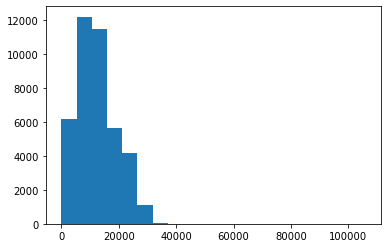

In [9]:
# Weight histogram
plt.hist(waste_aust_2019['Load Weight'], bins = 20)
plt.show() 

<AxesSubplot:>

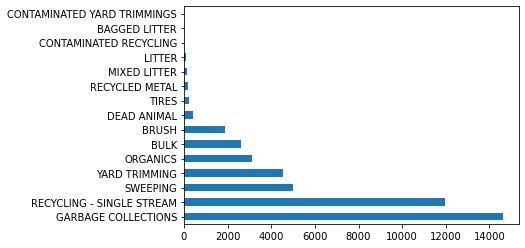

In [10]:
# Load Type countplot
waste_aust_2019['Load Type'].value_counts().plot(kind='barh')

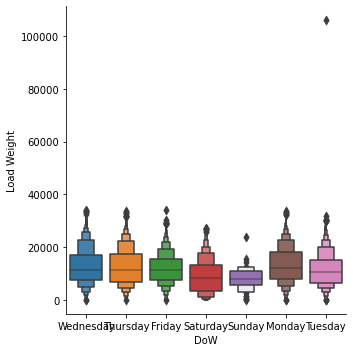

In [12]:
sns.catplot(x="DoW", y="Load Weight", kind="boxen",
            data=waste_aust_2019)

## Waste Routes

In [13]:
waste_routes = gpd.read_file('Garbage Routes.geojson')
waste_routes.head()

,rt_old,garb_day,landfill,garb_rt,super_num,op_type,garb_sup,geometry
0,None,Thursday,TDS,PAH83,697,Auto,Gilbert,"MULTIPOLYGON (((-97.70618 30.36742, -97.70723 ..."
1,PAM84,Monday,TDS,PAM54,500,Auto,Castillo,"MULTIPOLYGON (((-97.83237 30.16213, -97.83237 ..."
2,None,Monday,TDS,PAM71,596,Auto,Carnline,"MULTIPOLYGON (((-97.72977 30.19009, -97.72103 ..."
3,PAH75,Thursday,TDS,PAH54,500,Auto,Castillo,"MULTIPOLYGON (((-97.65374 30.26269, -97.65322 ..."
4,None,Wednesday,TDS,PAW71,596,Auto,Carnline,"MULTIPOLYGON (((-97.64683 30.38640, -97.64724 ..."


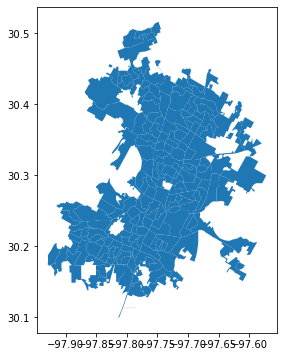

In [14]:
waste_routes.plot(figsize=(6, 6))
plt.show()

In [15]:
m = folium.Map(location=[30.30, -97.7], zoom_start=10, tiles='CartoDB positron')

for _, r in waste_routes.iterrows():
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'orange'})
    folium.Popup(r['garb_rt']).add_to(geo_j)
    geo_j.add_to(m)
m